In [1]:
import torch
from cibsde import nn, utils
import matplotlib.pyplot as plt
device = torch.device('cuda:0')

In [2]:
dx = 1
t = torch.tensor(1.,device=device)
D = torch.tensor(0.1,device=device)
r = torch.tensor([1],device=device)
R = 2
N = 100
batch = 512
epoch = 10**4
lr = 1e-3

def data_gen(batch):
    u1 = torch.rand([batch,dx],device=device)
    u2 = torch.rand([batch,dx],device=device)*(1-r/R/2)
    phi = 2 * torch.pi * u1
    theta = torch.arccos(1 - u2)
    theta[:,:-1] = 0
    x = torch.sin(theta) * torch.cos(phi)
    y = torch.sin(theta) * torch.sin(phi)
    z = torch.cos(theta)
    return torch.stack([x,y,z],dim=2).reshape([batch,dx*3])

def pc(i,x):
    x = x.reshape([batch*dx,3])
    x_polar = utils.polar_corr(x).reshape([batch*dx,2])
    return (x_polar[:,0]<torch.pi/4).reshape([batch,dx]).prod(dim=1,keepdim=True).float()

def refb(x):
    thetab = torch.arccos(r/R/2)
    x = x.reshape([batch*dx,3])
    x_polar = utils.polar_corr(x).reshape([batch,dx,2])
    out = (x_polar[:,:,0] >= thetab).reshape([batch*dx])
    xb = x_polar.clone()
    xb[:,:,0] = thetab
    xb = utils.euclid_corr(xb.reshape([batch*dx,2]))
    nb = torch.cat([xb[:,:1]*xb[:,2:],xb[:,1:2]*xb[:,2:],-xb[:,:2].norm(dim=1,keepdim=True)**2],dim=1)
    nb = nb / nb.norm(dim=1,keepdim=True)
    return xb, nb, out

def hitb(x):
    return torch.zeros(batch,device=device).bool()

def f(t,xt,p):
    return torch.zeros([batch,1],device=device)

model = nn.SphereIBSDE(
    dx = dx,
    t = t,
    f = f,
    D = D/r**2,
    pc = pc,
    data_gen = data_gen,
    N = N,
    refb = refb,
    hitb = hitb,
    param = False
).to(device)

In [3]:
train_params = {
    'epoch': epoch,
    'batch': batch,
    'lr': lr
}

loss_value = nn.train(
    model,
    train_params
)

10000/10000|##################################################|6656.26s  [Loss: 2.180094e-02] 
Training has been completed.


In [8]:
shape = [101,201]
theta = torch.linspace(0,torch.arccos(r[-1]/R/2),shape[0],device=device)
phi = torch.linspace(0,torch.pi*2,shape[1],device=device)
theta,phi = torch.meshgrid(theta,phi,indexing='ij')
x_polar = torch.stack([theta.reshape(shape[0]*shape[1]),phi.reshape(shape[0]*shape[1])],dim=1)
x = utils.euclid_corr(x_polar)
y = model.p(x).detach().cpu().reshape(shape)

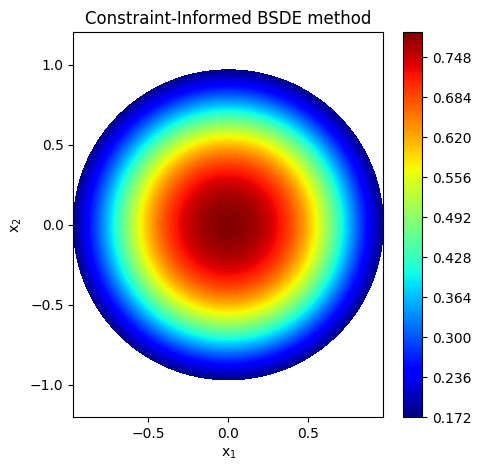

In [9]:
plt.figure(figsize=(5,5))
x = x.reshape([101,201,3]).cpu()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.axis('equal')
plt.contourf(x[:,:,0],x[:,:,1],y,200,cmap='jet')
plt.colorbar()
plt.title('Constraint-Informed BSDE method')
plt.show()